In [1]:
# Useful commamnds
!rm -rf /kaggle/working/*

Reference Github: https://github.com/BreezeWhite/oemer

In [2]:
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

doremi_dir = "/kaggle/input/doremi-raw-dataset/DoReMi_v1/"
IMAGE_WIDTH = 2475
IMAGE_HEIGHT = 1577

# Sample data

Importing sample image from the [DoReMi](https://github.com/steinbergmedia/DoReMi/?tab=readme-ov-file#OMR-metadata) dataset.

In [3]:
img_path = doremi_dir + 'Images/Alkan - Posement-001.png'
image = Image.open(img_path)

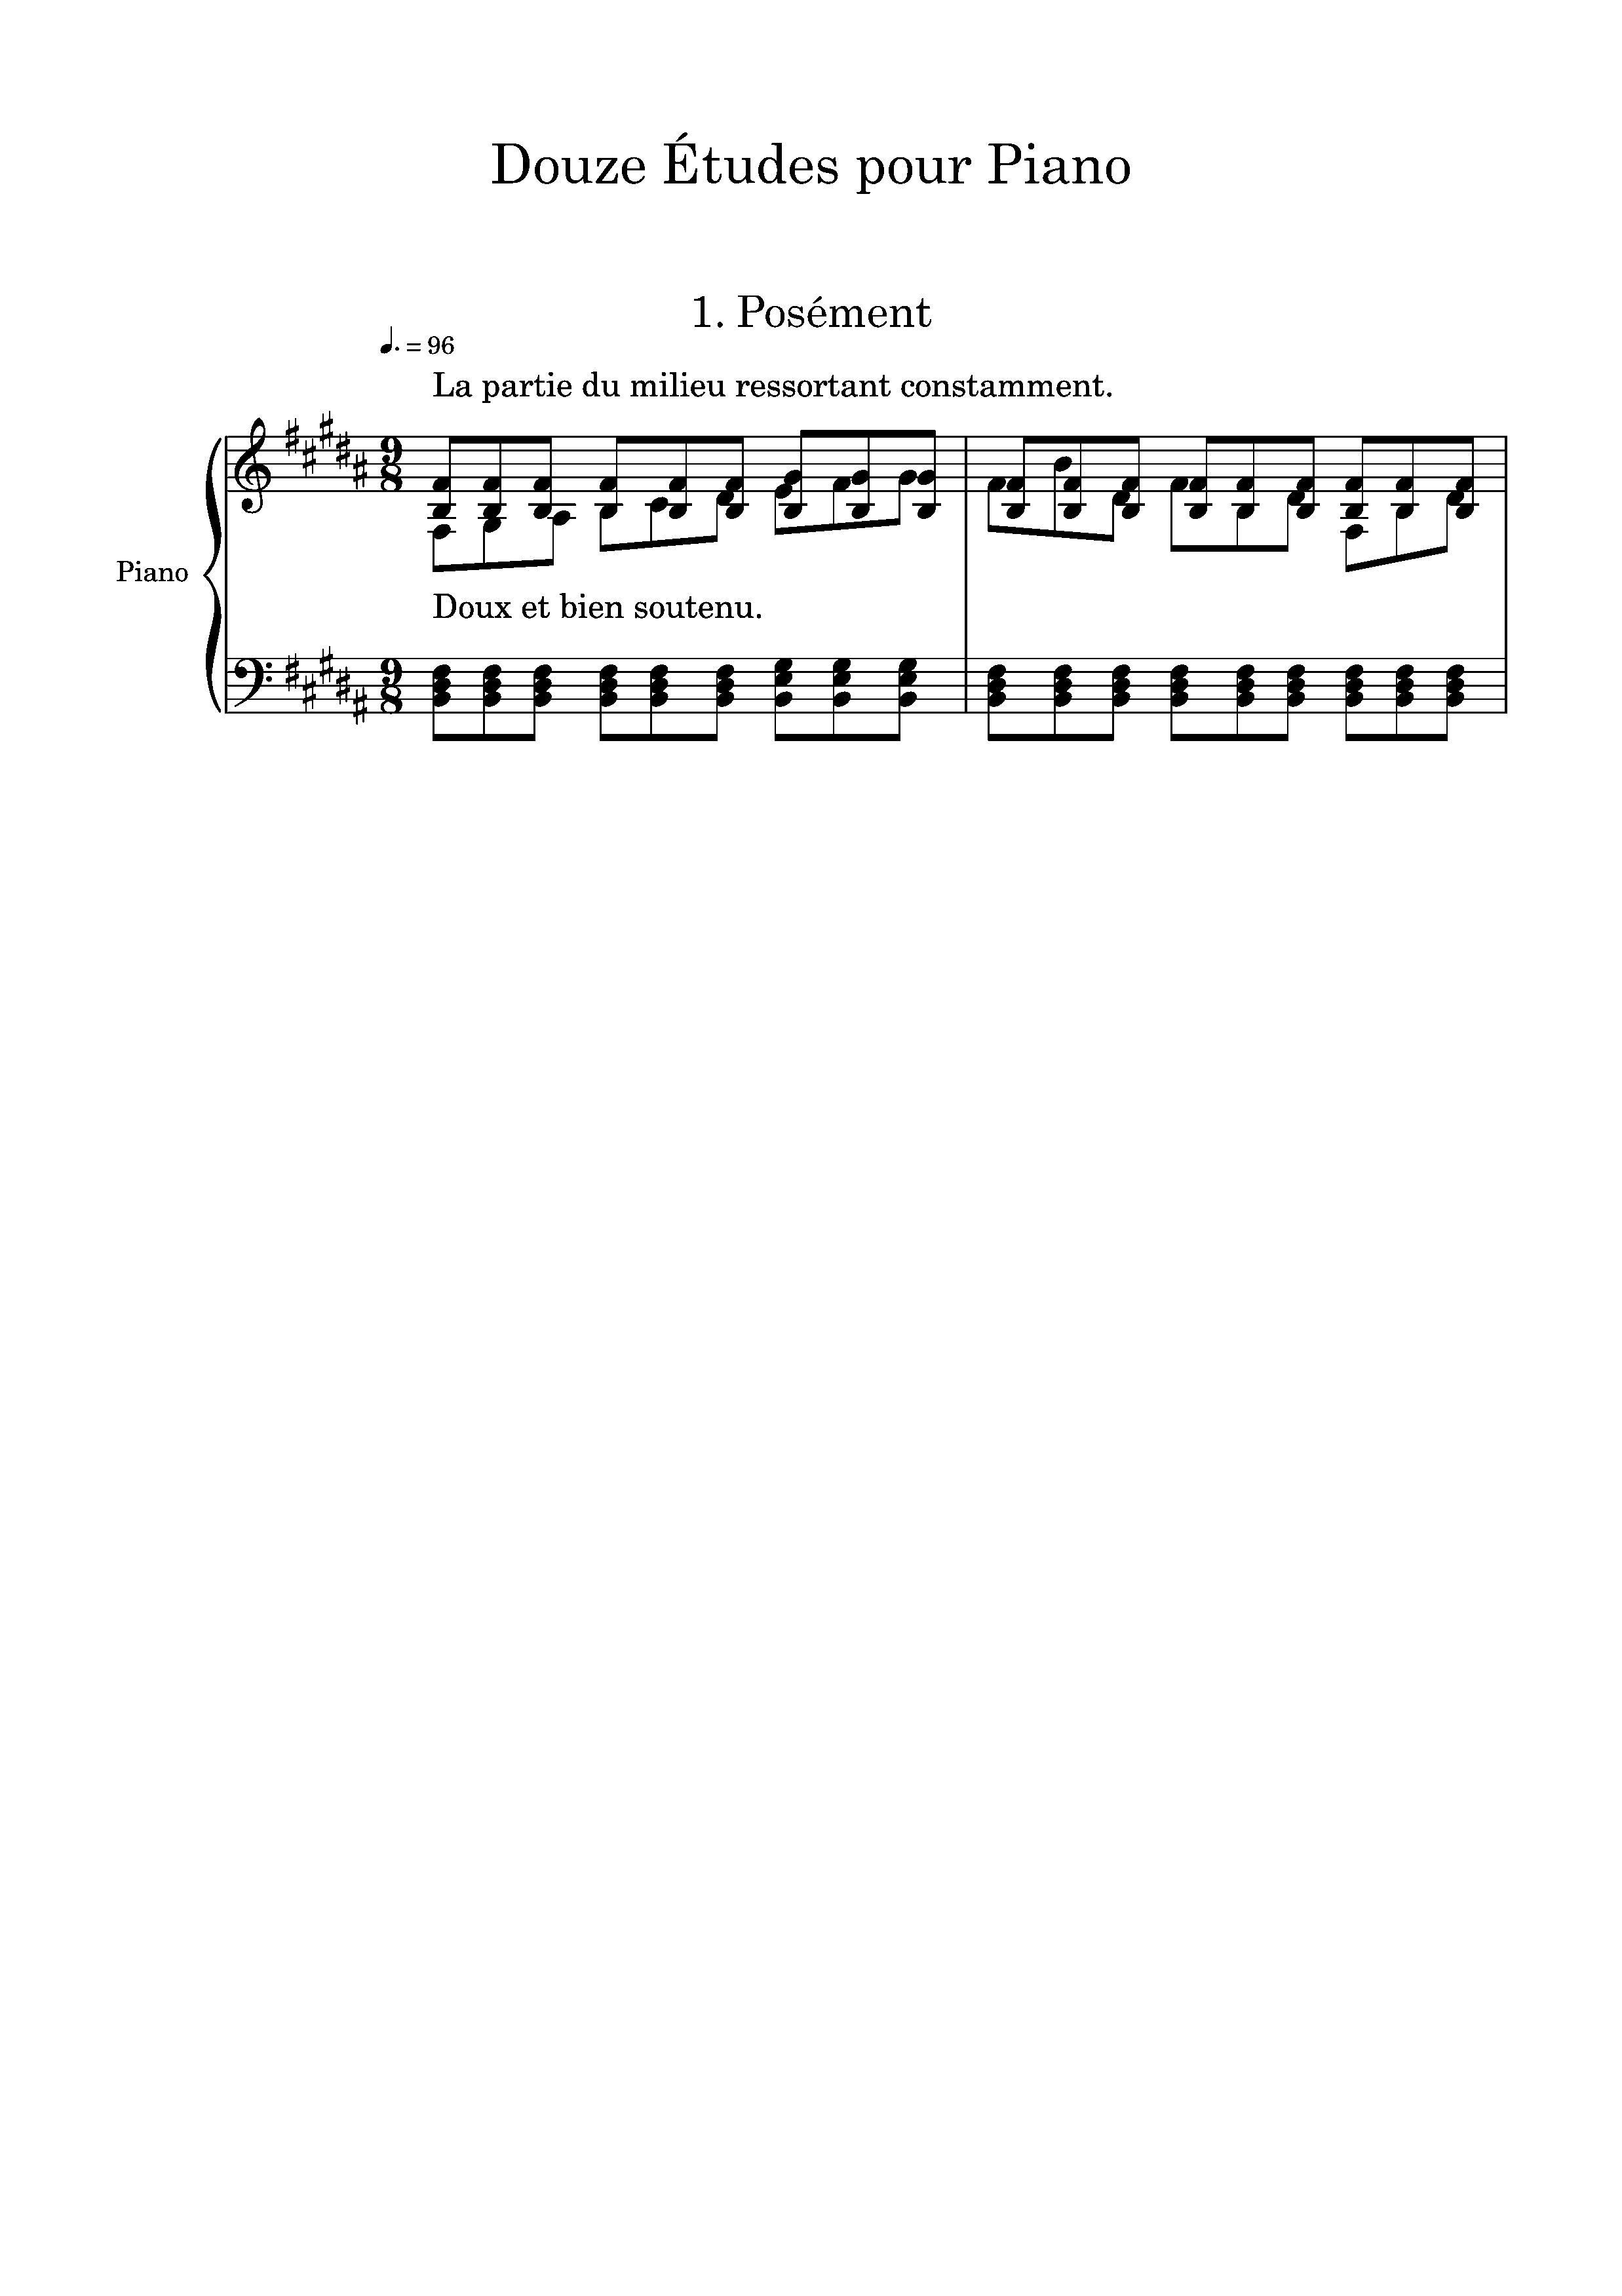

In [4]:
image

In [5]:
file_path = doremi_dir + 'OMR_XML/Alkan - Posement-layout-0-muscima.xml'
with open(file_path, 'r') as file:
    content = file.read(200)
    print(content)

<?xml version="1.0" encoding="utf-8"?>
<Pages><Page pageIndex="0"><Nodes><Node><Id>230</Id><ClassName>accidentalSharp</ClassName><Top>1049</Top><Left>539</Left><Width>21</Width><Height>59</Height><Mas


# Preprocessing Data

## Cropping Input Image
To adjust the size of our data, we wrote a python script to crop the input image. 

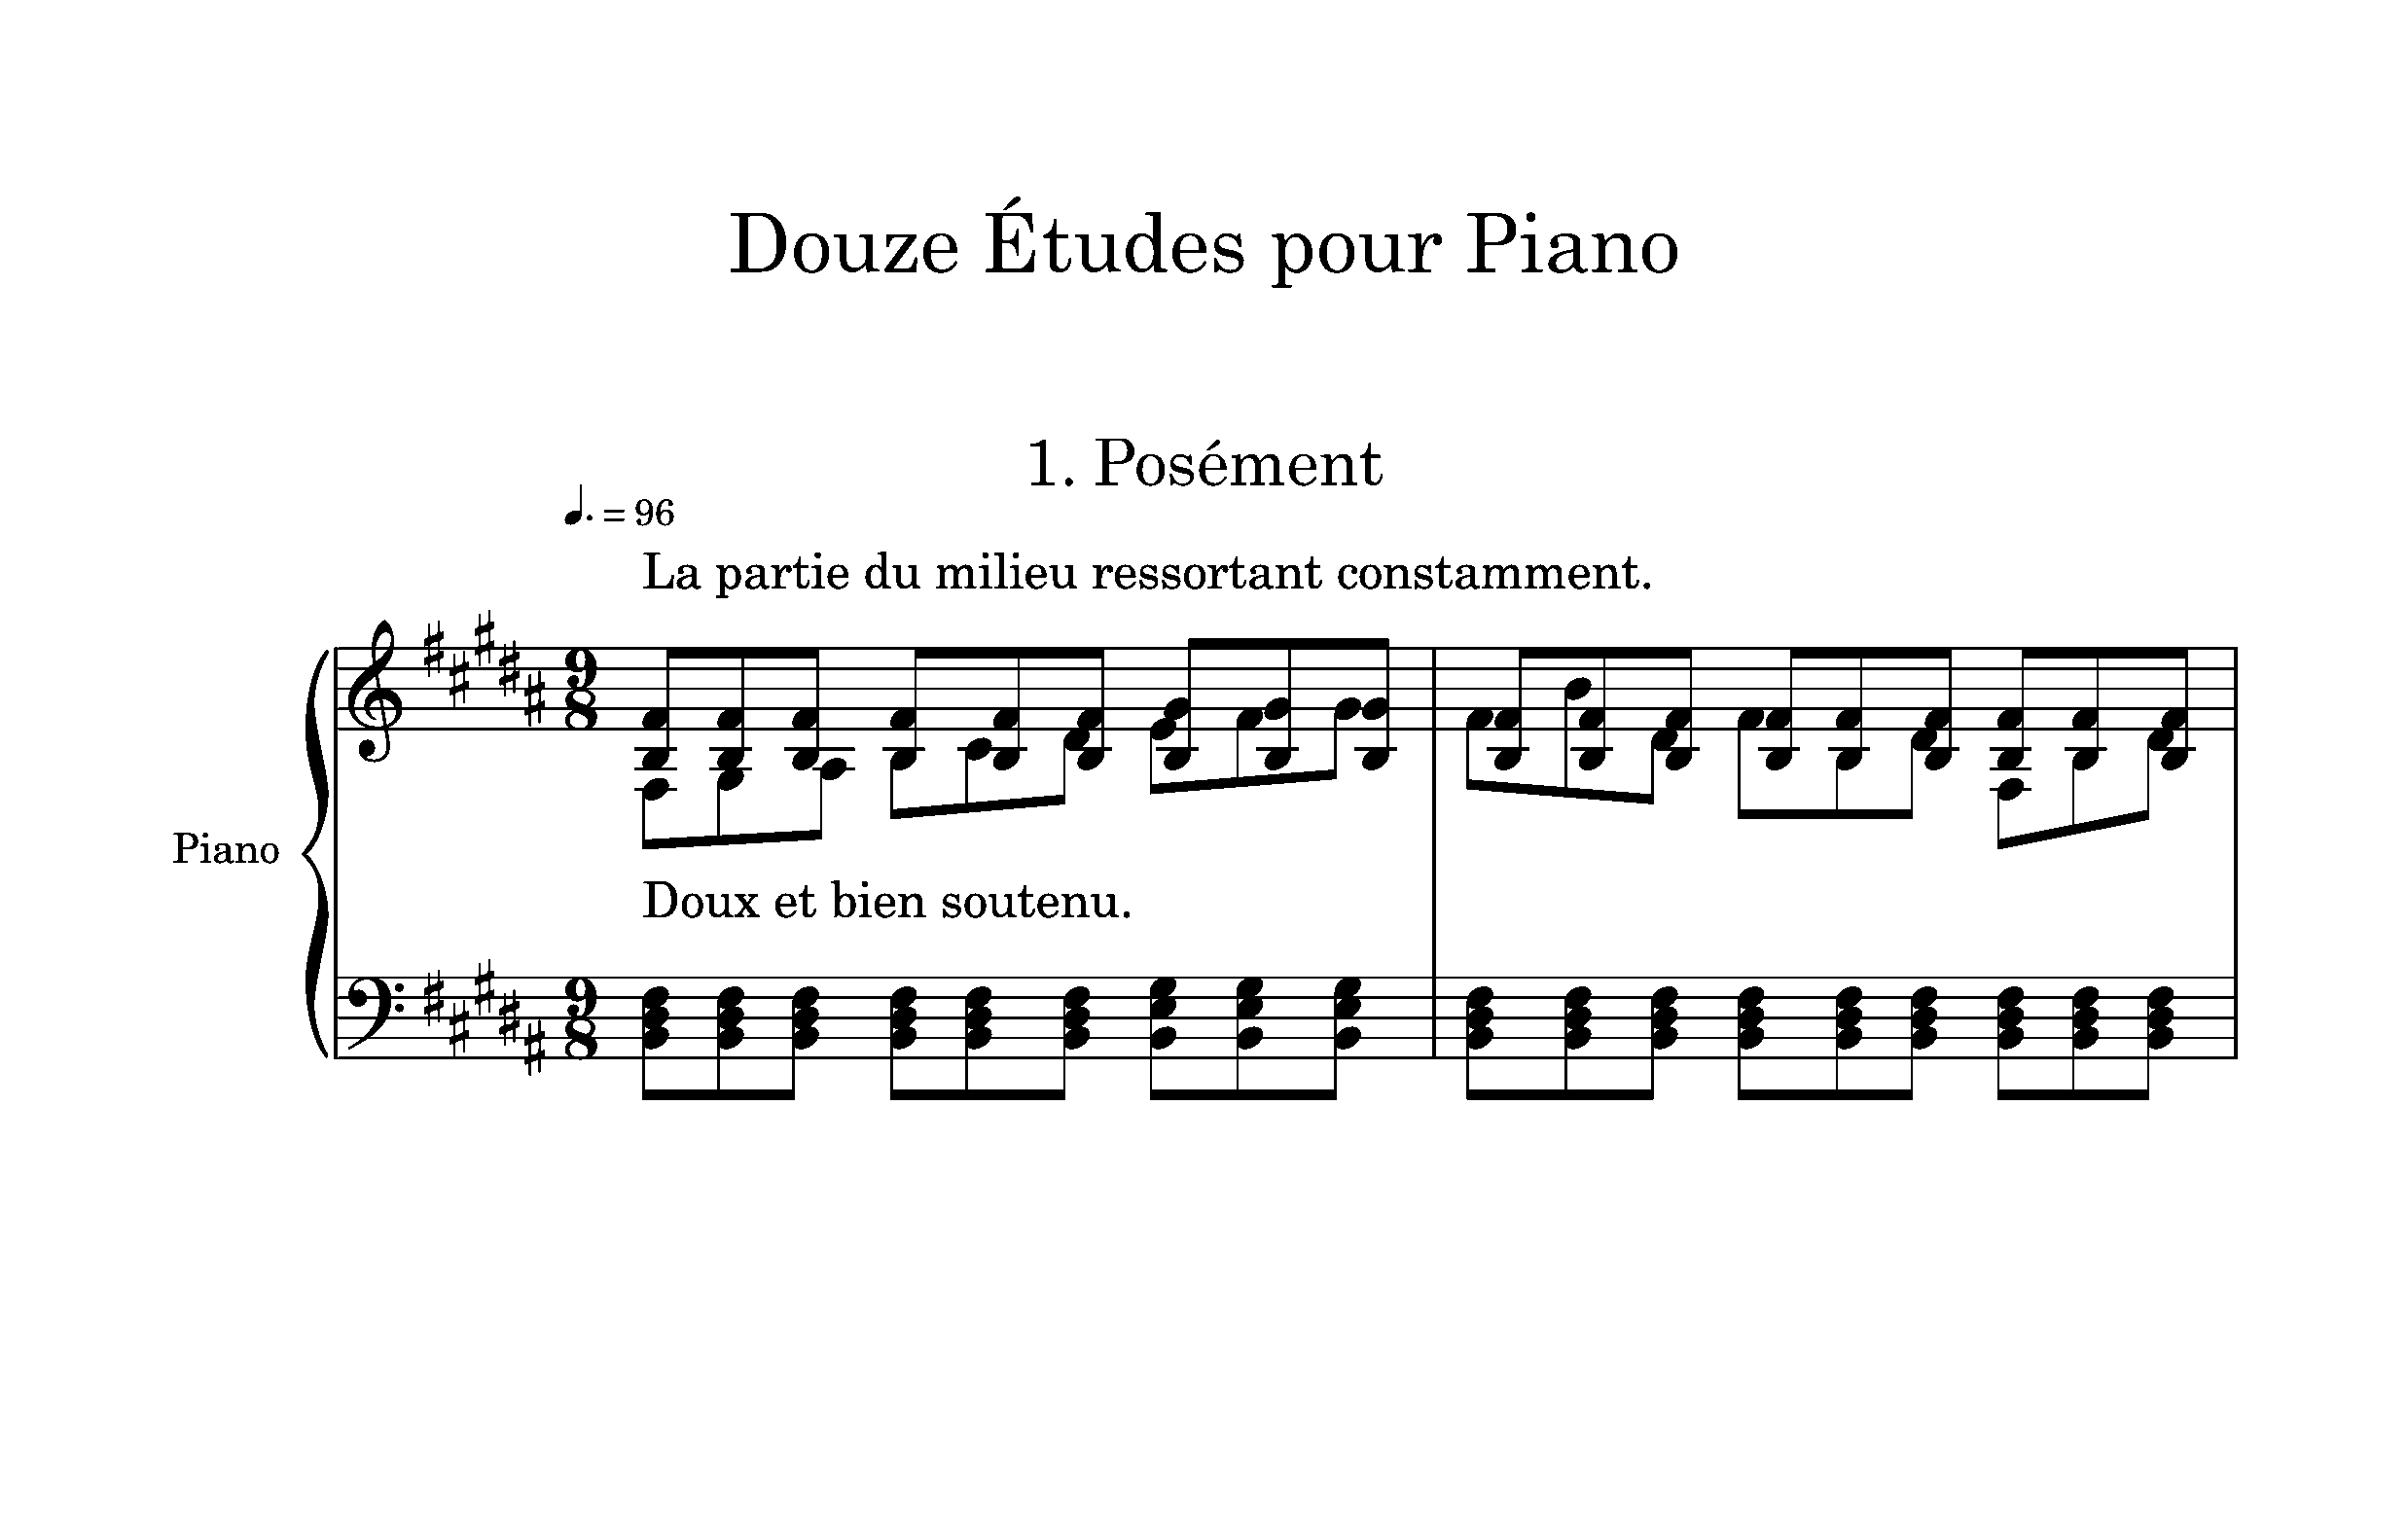

In [6]:
from IPython.display import display

def crop_top_half(image_path):
    """
    Crops the top half of the image.

    Parameters:
    - image_path: str, path to the input image.

    Returns:
    - cropped_image: PIL.Image.Image, the cropped top half of the image.
    """
    image = Image.open(image_path)

    width, height = image.size
    crop_height = height * 0.45
    crop_box = (0, 0, width, crop_height)
    cropped_image = image.crop(crop_box)
    
    return cropped_image

# Example usage
input_image_path = doremi_dir + 'Images/Alkan - Posement-001.png'
cropped_image = crop_top_half(input_image_path)

display(cropped_image)

## Staffline Extraction
First, we will extract stafflines. This step is the most important as the music scores are determined by their relative position to the stafflines. We will extract the following information for each staffline, which are fundamental for the later parts of this project. 

In [7]:
# example output of staff extraction
# Staff {
#     Center: 0.0 # y-center 
#     Upper bound: 150 # upper bound of the block
#     Lower bound: 200 # lower bound of the block
#     Unit size: 5.0 # distance between each stafflines
#     Track: 1 # for a two-handed piano score, track 1 would be for the left hand and track 2 would be for right hand
#     Group: 3 # for a two-handed piano score, two tracks are grouped into one
# }

In [8]:
class Line:
    def __init__(self) -> None:
        self.points = [] # stores the (x,y) pixels that make up the line
        self.label = "" # FIRST, SECOND, THIRD, FOURTH, FIFTH

    def add_point(self, x:int, y:int) -> None:
        self.points.append((x,y))
        self.y_center = None
        self.upper = None
        self.lower = None
        self.x_center = None
        self.x_left = None
        self.x_right = None 
        

In [9]:
class Staff:
    def __init(self) -> None:
        self.lines = List[Line]
        self.track = None
        self.group = None